## Wstępne przetwarzanie danych c.d.

Na danym etapie przeprowadzenie eksploracji danych jest bardzo ciężkim oraz czasochłonnym zadaniem ponieważ zbiór uczący nadal zawiera bardzo dużo kolumn. Więc następnym etapem filtracja cech pod względem właściwości statystycznych.

### Aktualny zakres:
- Transformacja zmiennej celi (do przeniesienia do innego rozdziału)
- Filtracja cech pod względem:
	-  cech stałych
	-  cech quasi-stałych
	-  cech duplikatów
	-  cech o dużej korelacji
- Pierwszy eksperyment uczenia modelu

### Planowane operacje i eksperymenty: 
- Redukcja cech umiejętności (ST, RB, ...) do jednej cechy (np "Skill") za pomocą PCA 
- Przetwarzanie danych odstających
- Normalizacja danych


### Importowanie potrzebnych bibliotek 

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

Po poprzedmin przetwarzaniu danych nasz zbiór znajduje się już w nowym pliku

## Wstęp

In [62]:
fifa_data = pd.read_csv('data_new_classes.csv')

In [63]:
cols =  ['Preferred Foot', 'Body Type' , 'Work Rate', 'Position']
fifa_data[cols] = fifa_data[cols].astype('category')

In [64]:
fifa_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16122 entries, 0 to 16121
Data columns (total 66 columns):
Age                16122 non-null int64
Overall            16122 non-null int64
Potential          16122 non-null int64
Preferred Foot     16122 non-null category
Weak Foot          16122 non-null float64
Skill Moves        16122 non-null float64
Work Rate          16122 non-null category
Body Type          16122 non-null category
Position           16122 non-null category
Height             16122 non-null float64
Weight             16122 non-null float64
LS                 16122 non-null int64
ST                 16122 non-null int64
RS                 16122 non-null int64
LW                 16122 non-null int64
LF                 16122 non-null int64
CF                 16122 non-null int64
RF                 16122 non-null int64
RW                 16122 non-null int64
LAM                16122 non-null int64
CAM                16122 non-null int64
RAM                16122 non-nu

In [65]:
fifa_no_category = fifa_data.select_dtypes(exclude=['category'])

### Usuwanie cech stałych

In [66]:
constant_filter = VarianceThreshold(threshold=0)

In [67]:
constant_filter.fit(fifa_no_category)

VarianceThreshold(threshold=0)

In [68]:
selected_features =  fifa_no_category.columns[constant_filter.get_support()]
constant_features = [feature for feature in fifa_no_category if feature not in selected_features]
constant_features

[]

Oryginalny zbiór uczący nie zawiera cech stałych

### Usuwanie quasi-stałych cech

In [69]:
VARIANCE_THRESHHOLD = 0.2
qconstant_filter = VarianceThreshold(threshold=VARIANCE_THRESHHOLD)
qconstant_filter.fit(fifa_no_category)
selected_features =  fifa_no_category.columns[qconstant_filter.get_support()]
qconstant_features = [feature for feature in fifa_no_category if feature not in selected_features]
qconstant_features

[]

Oryginalny zbiór uczący nie zawiera cech quasi-stałych

### Usuwanie Cech duplikatów

In [70]:
def find_duplicate_columns(data):
    no_duplicates_data = data.T.drop_duplicates(keep='first').T
    return [c for c in data.columns if c not in no_duplicates_data.columns]

In [71]:
duplicate_columns = find_duplicate_columns(fifa_data)
duplicate_columns

['ST',
 'RS',
 'CF',
 'RF',
 'RW',
 'CAM',
 'RAM',
 'CM',
 'RCM',
 'RM',
 'CDM',
 'RDM',
 'RWB',
 'CB',
 'RCB',
 'RB']

Widzimy że mamy cechy, które tylko powtażają pewną informacje, któtch nie potrzebujemy mieć w zbiorze uczącym 

In [72]:
fifa_data.drop(columns=duplicate_columns, axis=1, inplace=True)

In [73]:
fifa_data.shape

(16122, 50)

## Good players filtering 

In [74]:
fifa_data = fifa_data[fifa_data['Overall'] >=70]
fifa_data.shape

(5137, 50)

The reason of only filtering out 70+ rating players is to see how good players define their position and to find out how to become good player by choosing the right position based on player's attributes.
(translate)

## Label encoding

In [75]:
def encode_labels(col):
    label_encoder = LabelEncoder()
    transform = label_encoder.fit_transform(col)
    print(get_labels_map(label_encoder))
    return transform

def get_labels_map(le):
    return dict(zip(le.classes_, le.transform(le.classes_)))


fifa_categories = fifa_data.select_dtypes('category')
fifa_data[fifa_categories.columns] = fifa_data[fifa_categories.columns].apply(encode_labels)

{'Left': 0, 'Right': 1}
{'High/ High': 0, 'High/ Low': 1, 'High/ Medium': 2, 'Low/ High': 3, 'Low/ Low': 4, 'Low/ Medium': 5, 'Medium/ High': 6, 'Medium/ Low': 7, 'Medium/ Medium': 8}
{'Lean': 0, 'Normal': 1, 'Stocky': 2}
{'CB': 0, 'CM': 1, 'F': 2, 'LB': 3, 'LM': 4, 'RB': 5, 'RM': 6, 'ST': 7}


In [76]:
fifa_train_data = fifa_data.drop('Position', axis=1)
target = fifa_data['Position']

### Oversampling and undersampling

In [77]:
def draw_countplot(col):
    sns.countplot(col, order=col.value_counts().index)

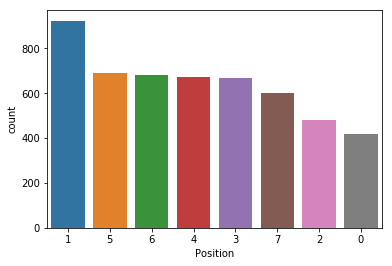

In [78]:
position = fifa_data['Position']
draw_countplot(position)

In [79]:
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, ADASYN

In [80]:
cc = ClusterCentroids(random_state=0)
rus = RandomUnderSampler(random_state=0)
ros = RandomOverSampler(random_state=0)
smote = SMOTE()
adasyn = ADASYN()
tl = TomekLinks()
blsmote = BorderlineSMOTE()

In [81]:
sampler = smote

In [82]:
X_resampled, y_resampled = sampler.fit_resample(fifa_train_data, target)

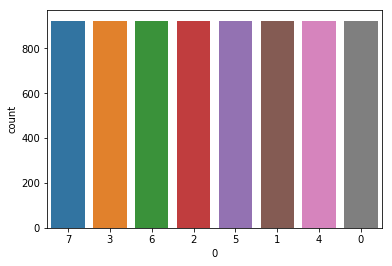

In [83]:
draw_countplot(pd.DataFrame(y_resampled)[0])

## Eksperyment uczenia modelu

### Train Test Split

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.33, random_state=42)

### Scaling

In [85]:
from sklearn.preprocessing import RobustScaler, StandardScaler

In [86]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled =  scaler.transform(X_test)

### Feature Selection

#### SelectKBest

In [87]:
from sklearn.feature_selection import SelectKBest, f_classif

In [88]:
k_best_selector = SelectKBest(f_classif, k=49)
X_train_scaled_selected = k_best_selector.fit_transform(X_train_scaled, y_train)
X_test_scaled_selected = k_best_selector.transform(X_test_scaled)

#### Rekurencyjna Eliminacja

In [89]:
from sklearn.feature_selection import RFECV

In [90]:
rfecv_selector = RFECV(estimator=RandomForestClassifier(n_estimators=100), cv=5, step=1, n_jobs=4, verbose=5)

In [91]:
# X_train_scaled_selected = rfecv_selector.fit_transform(X_train_scaled_selected, y_train)
# X_test_scaled_selected = rfecv_selector.transform(X_test_scaled_selected)

In [92]:
# rfecv_selector.n_features_

Selected features

In [93]:
# [f for f,s in zip(X_train.columns, rfecv_selector.support_) if s]

### Modeling

In [94]:
decision_tree_model = DecisionTreeClassifier()

In [95]:
decision_tree_model.fit(X_train_scaled_selected, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### Decision Tree 

In [96]:
pred = decision_tree_model.predict(X_test_scaled_selected)

In [97]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.63      0.66      0.64       300
           1       0.34      0.31      0.33       294
           2       0.54      0.60      0.57       298
           3       0.62      0.64      0.63       330
           4       0.38      0.38      0.38       304
           5       0.64      0.58      0.61       299
           6       0.38      0.38      0.38       299
           7       0.74      0.73      0.73       313

    accuracy                           0.54      2437
   macro avg       0.53      0.54      0.53      2437
weighted avg       0.54      0.54      0.54      2437



Na razie model radzi sobie bardzo słabo, co jest dość oczekiwanyn wynikiem. Ale możemy sprawdzić czy da się ten wynik poprawić za pomocą np użyciu bagginge, czyli w tym przypadku algorytm **Lasów Losowych** 

### Random Forest

In [98]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=2)
forest.fit(X_train_scaled_selected, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [99]:
forest_pred = forest.predict(X_test_scaled_selected)

In [100]:
print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

           0       0.66      0.89      0.76       300
           1       0.49      0.65      0.56       294
           2       0.62      0.70      0.66       298
           3       0.86      0.73      0.79       330
           4       0.68      0.42      0.52       304
           5       0.77      0.70      0.73       299
           6       0.60      0.43      0.50       299
           7       0.80      0.90      0.84       313

    accuracy                           0.68      2437
   macro avg       0.68      0.68      0.67      2437
weighted avg       0.69      0.68      0.67      2437



In [101]:
forest.feature_importances_

array([0.01526934, 0.01042111, 0.01448034, 0.03976361, 0.00878964,
       0.00887007, 0.01135618, 0.00730508, 0.01281088, 0.01528706,
       0.02239378, 0.01764411, 0.01636178, 0.02223765, 0.01957348,
       0.01936108, 0.02108643, 0.02191595, 0.02087136, 0.02372087,
       0.03180886, 0.03281928, 0.03454705, 0.01661605, 0.01966096,
       0.02310813, 0.01771718, 0.01769573, 0.02626607, 0.01404447,
       0.02078635, 0.02536951, 0.01687249, 0.01503827, 0.01661412,
       0.01722801, 0.01976886, 0.02356902, 0.01953493, 0.02119566,
       0.01832609, 0.02535583, 0.02248988, 0.0275936 , 0.01760654,
       0.01586955, 0.02212113, 0.03378739, 0.03706918])

### Grid Search

In [102]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
    'max_features': [6, 7, 8],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs =4, verbose = 2)

In [103]:
grid_search.fit(X_train_scaled_selected, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/home/mikita/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:   56.0s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [104]:
print(classification_report(grid_search.best_estimator_.predict(X_test_scaled_selected), y_test))

              precision    recall  f1-score   support

           0       0.91      0.67      0.77       411
           1       0.70      0.52      0.60       397
           2       0.71      0.62      0.66       340
           3       0.72      0.88      0.79       271
           4       0.40      0.74      0.52       167
           5       0.72      0.76      0.74       284
           6       0.42      0.60      0.50       210
           7       0.91      0.80      0.85       357

    accuracy                           0.69      2437
   macro avg       0.69      0.70      0.68      2437
weighted avg       0.73      0.69      0.70      2437



### KNN

In [105]:
from sklearn.neighbors import KNeighborsClassifier

In [106]:
scores = []
begin_n = 40
end_n = 60
for n in range(begin_n,end_n): 
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train_scaled_selected, y_train)
    score =  knn.score(X_test_scaled_selected, y_test)
    scores.append(score)

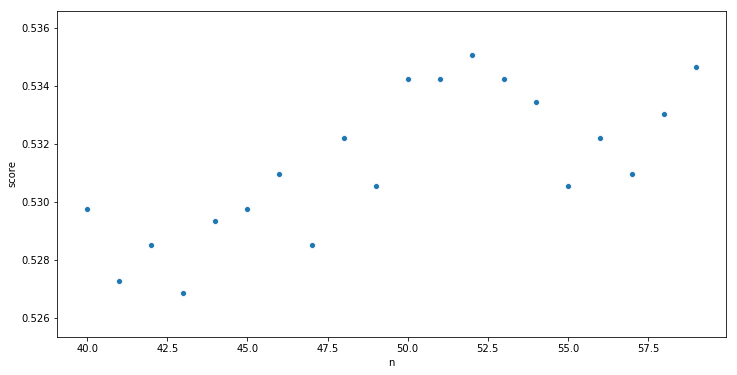

In [107]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='n', y='score',data=pd.DataFrame({'n':list(range(begin_n,end_n)), 'score':scores})) 